In [105]:
import numpy as np
import cv2 as cv
import va
from ipywidgets import interact

# Calcolo istogramma

""
""

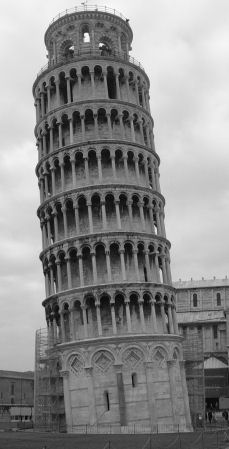

h_py,h_np,h_cv
,,

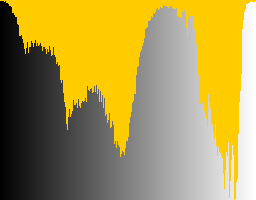
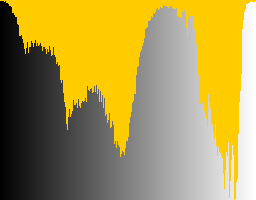
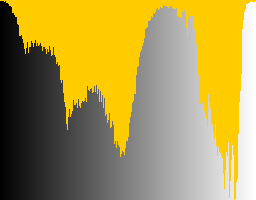

TypeError: 'module' object is not callable

In [106]:
def calc_hist_py(img):
    h = np.zeros(256, dtype=int)
    for p in np.nditer(img):
        h[p] += 1
    return h
def calc_hist_np(img):
    return np.histogram(img,256,[0,256])[0]
def calc_hist_cv(img):
    return cv.calcHist([img], [0], None, [256], [0, 256]).squeeze()
def convert_hist_to_img(vector, max_height = 200):
    vector = max_height * (vector / max(vector))
    img = np.ndarray((max_height,256,3), dtype=np.int64)
    for i in range(256):
        for j in range(max_height):
            if(vector[i] < j):
                img[j,i] = i
            else:
                img[j,i,2] = 255
                img[j,i,1] = 204
    return img
img = cv.imread("immagini/torre.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
va.show(img)
h_py = calc_hist_py(img)
h_np = calc_hist_np(img)
h_cv = calc_hist_cv(img)
va.show((convert_hist_to_img(h_py), "h_py"),(convert_hist_to_img(h_np), "h_np"),(convert_hist_to_img(h_cv), "h_cv"))
convert_hist_to_img:np(h_cv)

### Variazione luminosità e contrasto $f(I[y,x])=\alpha\cdot I[y,x]+\beta$
### Gamma correction $f(I[y,x])=(\frac{I[y,x]}{255})^\gamma\cdot 255$
### Contrast stretching $f(I[y,x])=255\cdot\frac{I[y,x]-\alpha}{\beta-\alpha}$

In [107]:
def apply_op(img,op):
    res = np.empty_like(img)
    h, w = res.shape
    for y in range(h):
        for x in range(w):
            pixel = op(img[y,x])
            if pixel > 255 : pixel = 255
            if pixel < 0 : pixel = 0
            res[y,x] = pixel
    return res

In [108]:
@interact(img_name=["immagini/radio2.png","immagini/torre.jpg","immagini/tbbt.jpg"],
          alpha=(0.5,1.6,0.1),
          beta=(-30,30,2),
          gamma=(0.1,10.0,0.1),
          op=(0,2))
def apply_operation(img_name, alpha, beta, gamma, op):
    img = cv.imread(img_name)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    w, h = img.shape
    f_op = None
    if op == 0 : f_op = lambda p: 255 * (p/255.0)**gamma
    if op == 1 : f_op = lambda p: alpha * p + beta
    if op == 2 : f_op = lambda p: 255 * ((p - np.percentile(img, 5)) / (np.percentile(img, 95) - np.percentile(img, 5)))
    img_mod = apply_op(img, f_op)
    va.show((img,"originale"),(img_mod,"aumento contrasto"))

interactive(children=(Dropdown(description='img_name', options=('immagini/radio2.png', 'immagini/torre.jpg', '…

### Equalizzazione $f(I[y,x])=\sum^v_{i=0}\frac{255\cdot h[i]}{\sum h[i]}$

Originale,Img Equalizzazione
,

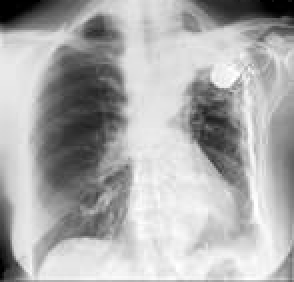
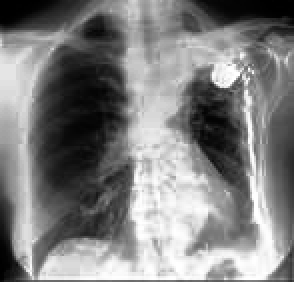

Img BGR,Wrong Eq.,Ok Eq. canale L
,,

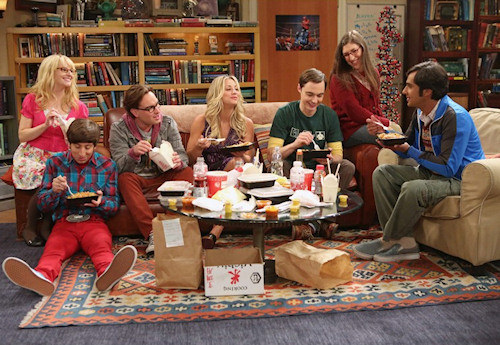
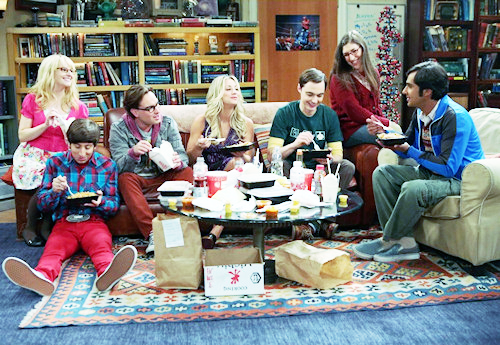
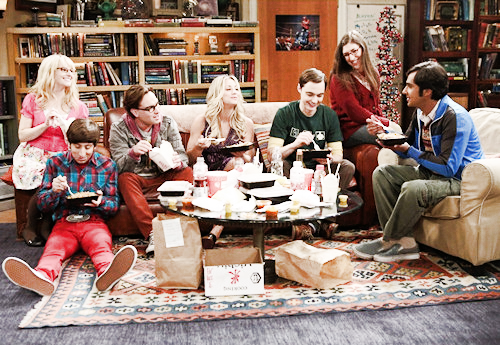

In [109]:
#Equalizzazione di un'immagine grayscale
img = cv.imread('immagini/radio1.png', cv.IMREAD_GRAYSCALE)
res = cv.equalizeHist(img)
va.show((img,"Originale"),(res,"Img Equalizzazione"))
# Equalizzazione di un'immagine a colori
# Esempio di come NON fare: equalizzazione di ciascun canale RGB
bgr = cv.imread('immagini/tbbt.jpg')
b, g, r = cv.split(bgr)
b_eq, g_eq, r_eq = [cv.equalizeHist(x) for x in (b, g, r)]
res_wrong = cv.merge((b_eq, g_eq, r_eq))
# Esempio di come procedere convertendo in HSL ed equalizzando L
hls = cv.cvtColor(bgr, cv.COLOR_BGR2HLS)
h, l, s = cv.split(hls)
l_eq = cv.equalizeHist(l)
hls_eq = cv.merge((h, l_eq, s))
res_ok = cv.cvtColor(hls_eq, cv.COLOR_HLS2BGR)
va.show((bgr,"Img BGR"), (res_wrong,"Wrong Eq."), (res_ok,"Ok Eq. canale L"))

""
""

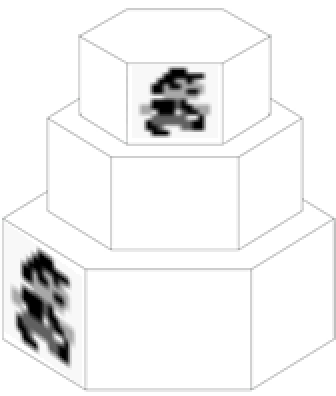

In [110]:
back = cv.imread('Immagini/cake.png')
m = cv.imread('Immagini/mario.png')
h, w = m.shape[:2]
m_pts = np.float32([[1,1],[w-2,1],[1,h-2]])
c_pts = np.float32([
[[ 68, 35],[106, 35],[ 68, 66]],
[[ 4,116],[ 38,140],[ 4,163]] ])

def drawPoints(img, lp):
    for pts in lp:
        for i in range(3):
            p = tuple(pts[i].round().astype(int))
            cv.drawMarker(img, p, (255,0,0), i, 3)
    return img

back_points = drawPoints(back.copy(), c_pts)
m_points = drawPoints(m.copy(), [m_pts])

for pts in c_pts:
    M = cv.getAffineTransform(m_pts,pts)
    cv.warpAffine(m, M, back.shape[1::-1], back, cv.INTER_LINEAR, cv.BORDER_TRANSPARENT)
va.show(back)

### Filtro Lineare $I'[y,x]=\sum_{i,j}\cdot w_{xy}[i,j]\cdot F[i,j]$

In [111]:
# Sorgente prof
def filter2D_py(img, f):
    h, w = img.shape
    kh, kw = f.shape
    dy, dx = kh//2, kw//2
    imgb = cv.copyMakeBorder(img, dy, dy, dx, dx, cv.BORDER_DEFAULT)
    res = np.zeros(img.shape, dtype=np.int16)
    for y in range(h):
        for x in range(w):
            s = 0
            for i in range(kh):
                for j in range(kw):
                    # N.B. sarebbe imgb[(dy+y)+(i-dy), (dx+x)+(j-dx)]
                    s += imgb[y+i, x+j]*f[i, j]
            res[y, x] = s
    return res

def filter2D_np(img, f):
    h, w = img.shape
    kh, kw = f.shape
    dy, dx = kh//2, kw//2
    imgb = cv.copyMakeBorder(img, dy, dy, dx, dx, cv.BORDER_DEFAULT)
    res = np.zeros(img.shape, dtype=np.int16)
    for y in range(h):
        for x in range(w):
            res[y, x] = (imgb[y:y+kh, x:x+kw]*f).sum()
    return res

# Applicazione di un filtro lineare a un'immagine con OpenCV
# Il risultato è memorizzato su un'immagine di interi con segno a 16 bit
def filter2D_cv(img, f):
    return cv.filter2D(img, cv.CV_16S, f)

# Misura del tempo di esecuzione delle tre implementazioni
# con un filtro 9x9 con tutti i coefficienti pari a uno.
img = cv.cvtColor(cv.imread('Immagini/bolts.png'), cv.COLOR_BGR2GRAY)
f = np.ones((9,9))
implementazioni = [filter2D_py, filter2D_np, filter2D_cv]

## Filtro Lineare separabile

In [112]:
def sepFilter2D_py(img, fX, fY):
    fX, fY = fX.ravel(), fY.ravel()
    h, w = img.shape
    kw, kh = fX.size, fY.size
    dy, dx = kh//2, kw//2
    imgb = cv.copyMakeBorder(img, 0, 0, dx, dx, cv.BORDER_DEFAULT)
    t = np.empty(img.shape, dtype=np.int16)
    for y in range(h):
        for x in range(w):
            t[y, x] = sum(imgb[y, x+j]*fX[j] for j in range(kw))
    tb = cv.copyMakeBorder(t, dy, dy, 0, 0, cv.BORDER_DEFAULT)
    res = np.empty(img.shape, dtype=np.int16)
    for y in range(h):
        for x in range(w):
            res[y, x] = sum(tb[y+i, x]*fY[i] for i in range(kh))
    return res

def sepFilter2D_np(img, fX, fY):
    fX, fY = fX.ravel(), fY.ravel()
    h, w = img.shape
    kw, kh = fX.size, fY.size
    dy, dx = kh//2, kw//2
    imgb = cv.copyMakeBorder(img, 0, 0, dx, dx, cv.BORDER_DEFAULT)
    t = np.empty(img.shape, dtype=np.int16)
    for y in range(h):
        for x in range(w):
            t[y, x] = (imgb[y, x:x+kw]*fX).sum()
    tb = cv.copyMakeBorder(t, dy, dy, 0, 0, cv.BORDER_DEFAULT)
    res = np.empty(img.shape, dtype=np.int16)
    for y in range(h):
        for x in range(w):
            res[y, x] = (tb[y:y+kh, x]*fY).sum()
    return res

def sepFilter2D_cv(img, fx, fy):
    return cv.sepFilter2D(img, cv.CV_16S, fx, fy)

img = cv.cvtColor(cv.imread('Immagini/bolts.png'), cv.COLOR_BGR2GRAY)
f = np.ones((9,9))
fx, fy = np.ones((9,1)), np.ones((1,9))
print("Verifica: ", np.array_equal(fx*fy, f))
implementazioni = [sepFilter2D_py, sepFilter2D_np, sepFilter2D_cv]


Verifica:  True


In [113]:
dim = 3
f_id = np.array(np.tile([0],dim**2), dtype=int).reshape((dim,dim))
f_id[dim//2,dim//2] = 1
filters = [f_id]

In [114]:
@interact(filters_id=(0,len(filters)-1))
def fun(filters_id):
    print(filters[filters_id])
    return None

interactive(children=(IntSlider(value=0, description='filters_id', max=0), Output()), _dom_classes=('widget-in…

## sharpening filter

In [115]:
##Bordi immagini 3D
##Heightmap terreno